# 1 Installation

* `torch`: Used for building and training neural networks.
* `DataLoader` & `Dataset`: Used for handling data loading and batching.
* `transforms`: HuggingFace library used for preprocessing images.
* `ViTForImageClassification`: Used for creating a model model and its preprocessing pipeline.
* `pandas`: Used for reading and writing CSV files.
* `PIL`: Used for manipulating image files.
* `os`: Used for interacting with the file system.

In [1]:
import os
import sys
print(f"Python executable: {sys.executable}")

Python executable: /Users/martincastro/Downloads/img/venv/bin/python


In [2]:
import pandas as pd
print("Pandas version:", pd.__version__)

Pandas version: 2.0.3


In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

In [5]:
import torchvision.transforms as transforms

/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/martincastro/Downloads/img/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import ViTForImageClassification

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
from PIL import Image

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import random
from datetime import datetime, timedelta
import time

In [11]:
from typing import List, Tuple

# 2 Settings

In [12]:
LABELS = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [13]:
BATCH_SIZE = 32  # Samples per batch to load during training.

In [14]:
IMAGE_SIZE = 224  # Balance between image detail and computational cost.

In [15]:
SAMPLE_COLUMNS = 5
SAMPLE_ROWS = 2

In [16]:
RANDOM_STATE = 53  # Seed for randomized functions.

In [17]:
VALIDATION_SPLIT_RATIO = 0.2  # Ratio of validation datapoints.
TEST_SPLIT_RATIO = 0.5  # Ratio of test datapoints.

In [18]:
EPOCHS = 100  # Iterations during the training process.

In [19]:
PROCESSOR = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Processor:', PROCESSOR)

Processor: cpu


In [20]:
EARLY_STOPPING_PATIENCE = 3  # Number of epochs to wait for improvement before stopping

In [21]:
DROPOUT_RATE = 0.1  # Probability of dropping a weight during the training process.

In [22]:
GRADIENT_ACCUMULATION = 4  # Amount of batches to compute before optimizing the model.

# 3 Data Loading

In this section, we define a custom dataset class `ApparelDataset` that extends the `Dataset` class from PyTorch. This custom dataset is designed to load images and their corresponding labels from a CSV file and a specified directory.

In [23]:
class ApparelDataset(Dataset):
    def __init__(self, df: pd.DataFrame, images_path: str, preprocessing: transforms.Compose) -> None:
        assert os.path.isdir(images_path)
        self.df = df
        self.images_path = images_path
        self.preprocessing = preprocessing

    @classmethod
    def load(cls, csv_path: str, images_path: str, preprocessing: transforms.Compose) -> 'ApparelDataset':
        assert os.path.isfile(csv_path)
        return cls(pd.read_csv(csv_path), images_path, preprocessing)
    
    def __len__(self) -> int:
        return len(self.df)

    def _get_id_by_position(self, position: int) -> int:
        assert position < len(self)
        return self.df.iloc[position, 0]

    def _get_image_name_by_position(self, position: int) -> str:
        return f'{self._get_id_by_position(position)}.png'

    def _get_image_path_by_position(self, position: int) -> str:
        image_path: str = os.path.join(self.images_path, self._get_image_name_by_position(position))
        assert os.path.isfile(image_path), image_path
        return image_path

    def _get_image_by_position(self, position: int) -> Image:
        image_path = self._get_image_path_by_position(position)
        image = Image.open(image_path).convert("RGB")
        return self.preprocessing(image)

    def _get_label_by_position(self, idx: int) -> int:
        return self.df.iloc[idx, 1]

    def __getitem__(self, position: int):
        return self._get_image_by_position(position), self._get_label_by_position(position)


In [24]:
preprocessing = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

train_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=preprocessing)
print("Training dataset:", train_dataset, len(train_dataset), "records.")

Training dataset: <__main__.ApparelDataset object at 0x12a2d3ca0> 60000 records.


# 4 Initial Exploratory Analysis

Performing an initial exploratory analysis of our dataset to understand its content. Additionally, plotting the distribution of labels to ensure the dataset is balanced.

In [25]:
print(train_dataset.df.dtypes)

id       int64
label    int64
dtype: object


In [26]:
def sample_dataset(dataset: Dataset) -> None:
    random_indices = random.sample(range(len(dataset)), SAMPLE_ROWS * SAMPLE_COLUMNS)
    random_images = [dataset[i][0] for i in random_indices]
    random_labels = [dataset[i][1] for i in random_indices]
    sample_images(random_images, random_labels)

In [27]:
def sample_images(images: List[np.array], labels: List[int]) -> None:
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        ax = plt.subplot(SAMPLE_ROWS, SAMPLE_COLUMNS, i + 1)  # Show 2 rows of 5 images.
        img = images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.imshow(img)
        plt.title(LABELS[labels[i].item()])  # The title of each image is the label.
        plt.axis("off")  # Hide the X and Y grid.
    plt.show()

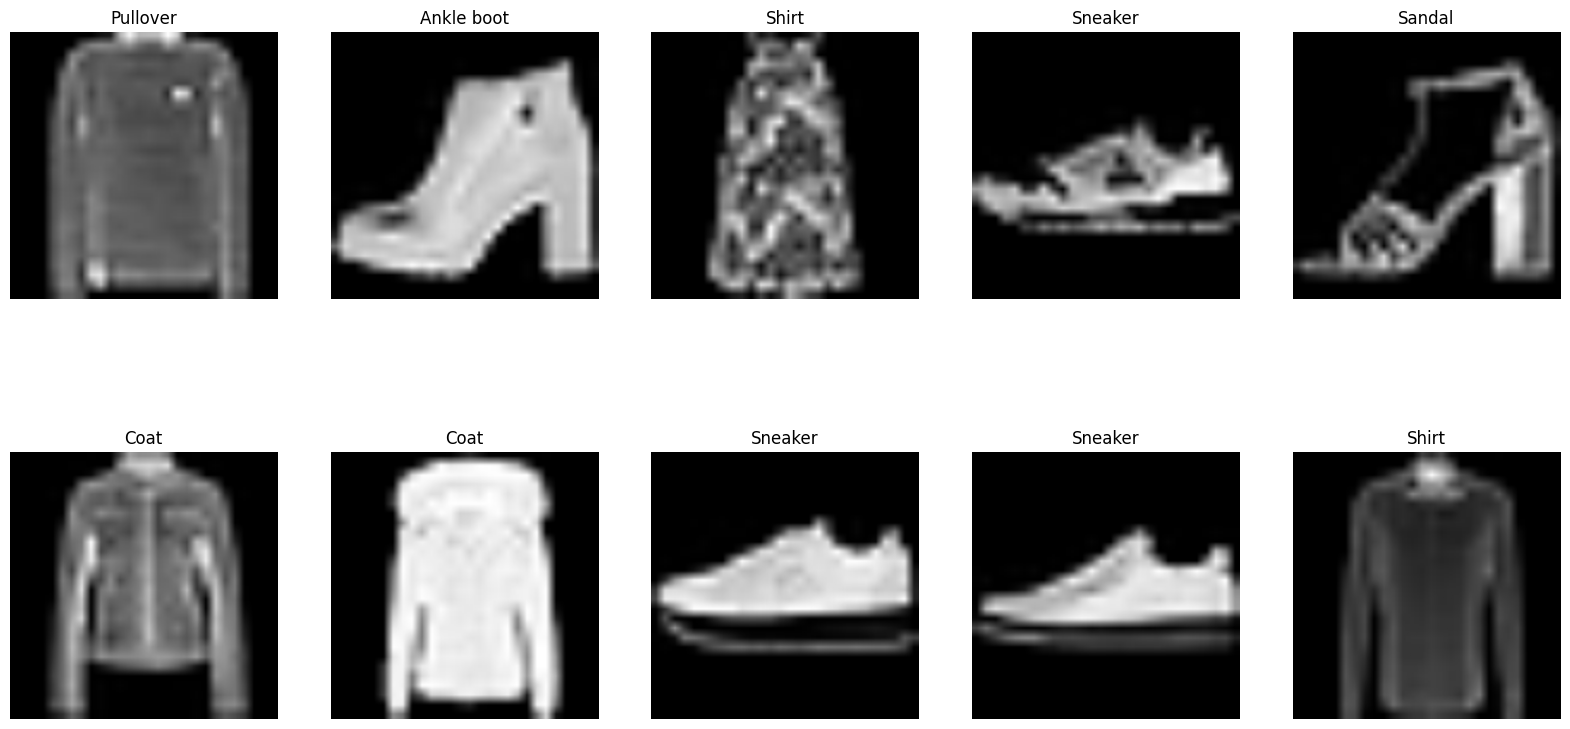

In [28]:
sample_dataset(train_dataset)

In [29]:
def plot_labels(dataset: Dataset) -> None:
    df = dataset.df
    df['label_names'] = df['label'].map(LABELS)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['label_names'], bins=len(df['label'].unique()), kde=False)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

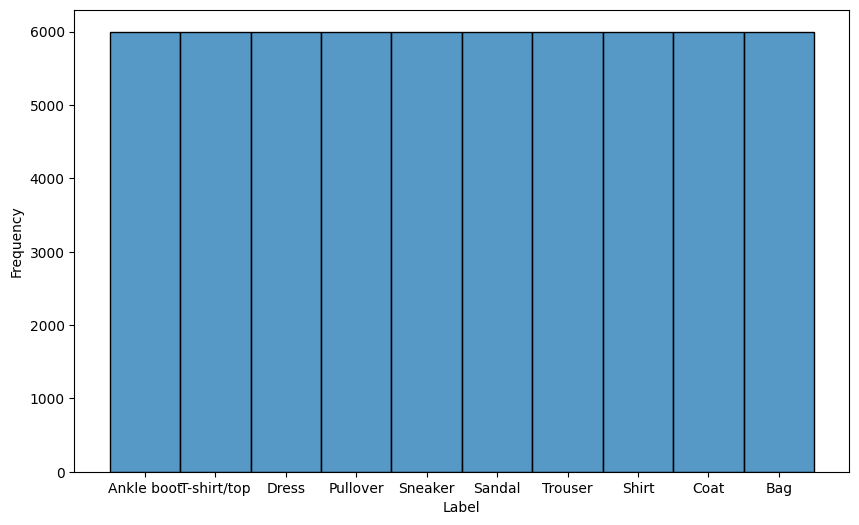

In [30]:
plot_labels(train_dataset)

# 5 Data Cleaning

Checking for null and duplicated values in the dataset. Fortunately, this dataset is already clean and balanced.

In [31]:
print("Null ids:", train_dataset.df.id.isnull().sum())

Null ids: 0


In [32]:
print("Null labels:", train_dataset.df.label.isnull().sum())

Null labels: 0


In [33]:
print("Duplicated rows:", train_dataset.df.duplicated().sum())

Duplicated rows: 0


# 6 Data Augmentation

Increasing the diversity of the training dataset to improve the robustness of our machine learning model. The augmented images are then combined with the original training dataset. This combined dataset is used to train the model.

In [34]:
class ApparelStackedDataset(Dataset):
    def __init__(self, *datasets: List[ApparelDataset]) -> None:
        self.datasets = list(datasets)
    
    def __len__(self) -> int:
        return sum([len(dataset) for dataset in self.datasets])

    @property
    def df(self) -> pd.DataFrame:
        return pd.concat([dataset.df for dataset in self.datasets], ignore_index=True)
    
    def _map_position(self, position: int) -> Tuple[int]:
        offset = 0
        for dataset in self.datasets:
            if position < len(dataset):
                return offset, position
            position -= len(dataset)
            offset += 1
            assert position >= 0
        raise IndexError('Stacked dataset index out of range!')

    def __getitem__(self, position: int):
        offset, relative_position = self._map_position(position)
        return self.datasets[offset][relative_position]

In [35]:
augmentation = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.1),  # Horizontally flip the input with a given probability.
    transforms.RandomRotation(degrees=90),  # Rotate the input by angle.
    transforms.RandomPerspective(p=0.1),  # Perform a random perspective transformation of the input with a given probability.
    # transforms.RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=True),  # Crop a random portion of the input and resize it to a given size.
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmented_dataset = ApparelDataset.load(csv_path='data/train.csv', images_path='data/train', preprocessing=augmentation)
print("Augmentation dataset:", augmented_dataset, len(augmented_dataset), "records")

Augmentation dataset: <__main__.ApparelDataset object at 0x1642e9bb0> 60000 records


In [36]:
augmented_train_dataset = ApparelStackedDataset(train_dataset, augmented_dataset)
print("Augmented training dataset dataset:", augmented_train_dataset, len(augmented_train_dataset), "records")

assert len(augmented_train_dataset) == len(train_dataset) + len(augmented_dataset)
assert augmented_train_dataset[0][0].equal(train_dataset[0][0])
assert augmented_train_dataset[0][1] == train_dataset[0][1]
# assert augmented_train_dataset[len(train_dataset)][0].equal(augmented_dataset[0][0])  # Reading the image generates a random variant.
assert augmented_train_dataset[len(train_dataset)][1] == augmented_dataset[0][1]

Augmented training dataset dataset: <__main__.ApparelStackedDataset object at 0x1642f38b0> 120000 records


# 7 Post-Cleaning Exploratory Analysis

Repeating the exploratory analysis to verify the effectiveness of the data cleaning and augmentation steps. This ensures the data augmentation step has not created weird things.

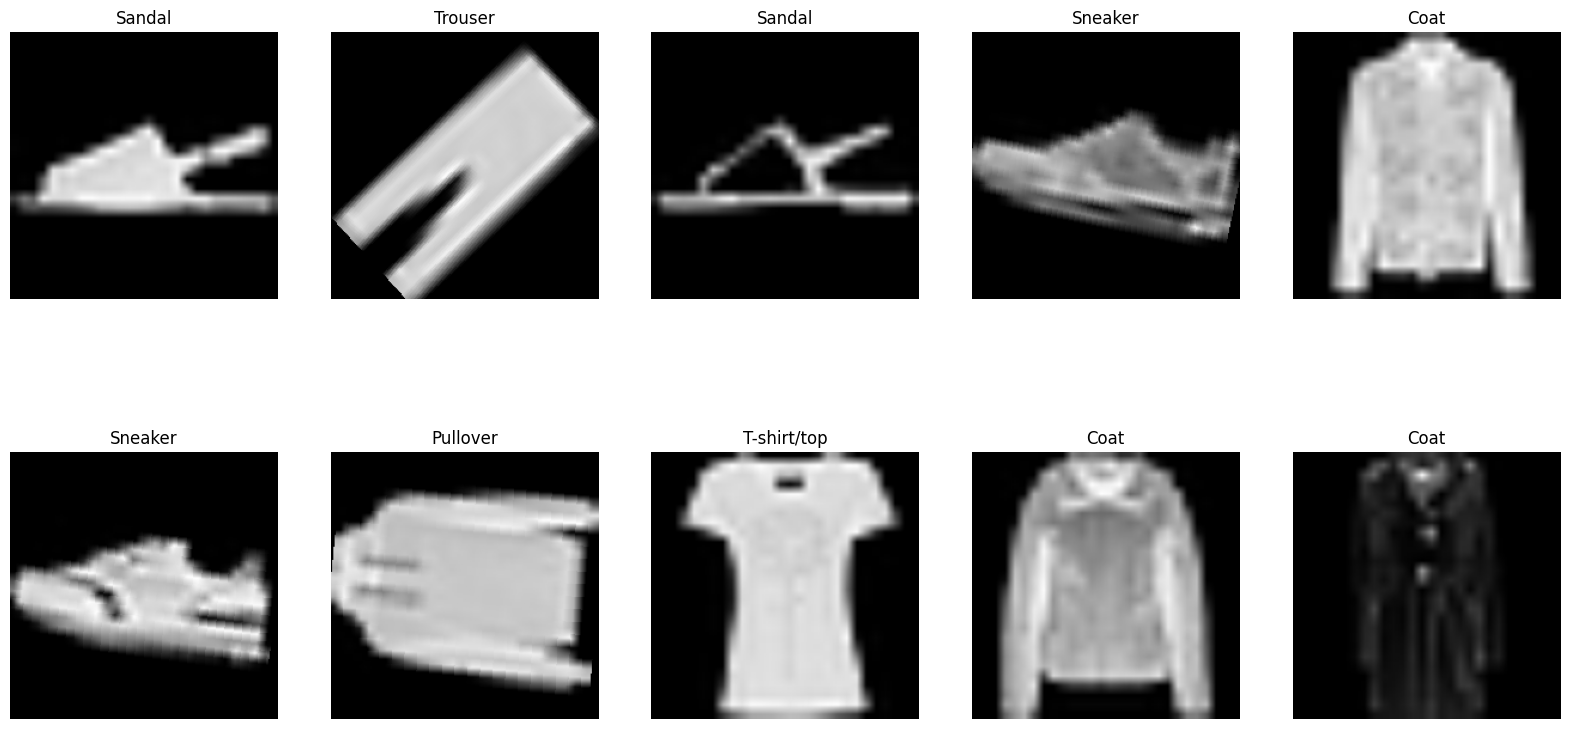

In [37]:
sample_dataset(augmented_train_dataset)

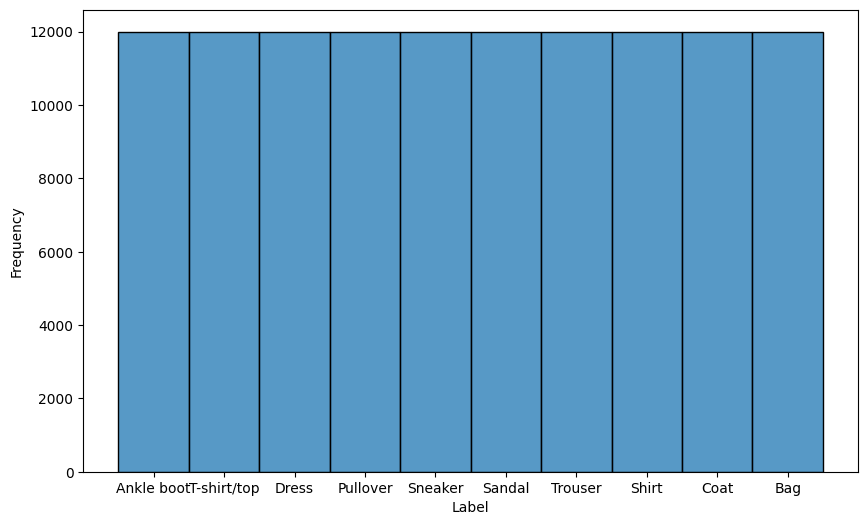

In [38]:
plot_labels(augmented_train_dataset)

# 8 Training and Validation Splitting

Splitting the augmented training dataset into training and validation sets using stratified sampling to maintain the same class distribution across both sets.

In [39]:
df = augmented_train_dataset.df
train_indices, val_test_indices = train_test_split(
    list(range(len(augmented_train_dataset))), 
    test_size=VALIDATION_SPLIT_RATIO, 
    stratify=df.label, 
    random_state=RANDOM_STATE
)
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=TEST_SPLIT_RATIO, 
    stratify=[df.label[i] for i in val_test_indices], 
    random_state=RANDOM_STATE
)
assert len(augmented_train_dataset) == len(train_indices) + len(test_indices) + len(val_indices)


print("Training indices:", train_indices[:10], "...")
print("Test indices:", test_indices[:10], "...")
print("Validation indices:", val_indices[:10], "...")

Training indices: [106888, 74770, 61998, 2921, 111450, 43470, 108759, 40147, 49076, 17977] ...
Test indices: [12162, 65108, 758, 40220, 116711, 36260, 67648, 13729, 63689, 110307] ...
Validation indices: [101185, 62371, 55139, 36801, 19630, 51333, 96458, 100821, 10057, 62542] ...


In [40]:
train_subset = Subset(augmented_train_dataset, train_indices)
test_subset = Subset(augmented_train_dataset, test_indices)
val_subset = Subset(augmented_train_dataset, val_indices)
assert len(train_subset) + len(test_subset) + len(val_subset) == len(augmented_train_dataset)
print("Training dataset:", train_subset, len(train_subset), "records")
print("Test dataset:", test_subset, len(test_subset), "records")
print("Validation dataset:", val_subset, len(val_subset), "records")

Training dataset: <torch.utils.data.dataset.Subset object at 0x1646e53a0> 96000 records
Test dataset: <torch.utils.data.dataset.Subset object at 0x1646e5280> 12000 records
Validation dataset: <torch.utils.data.dataset.Subset object at 0x1646e50a0> 12000 records


In [41]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

# 8 Model Preparation

Loading a pre-trained Vision Transformer model specifically designed for image classification with 10 labels using `ViTForImageClassification` from the Hugging Face, which is configured for a GPU (if available). Additionally, an Adam optimizer is set up with a learning rate of `1e-4` to adjust the model's parameters during training, and a cross-entropy loss function is defined to measure the performance of the model by comparing its predictions against the true labels.

In [42]:
class ApparelsModel(nn.Module):
    def __init__(self, base_model, num_labels):
        super(ApparelsModel, self).__init__()
        self.base_model = base_model
        self.new_layers = nn.Sequential(
            nn.Linear(base_model.classifier.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(1024, 512),
            nn.Dropout(DROPOUT_RATE),  # Adding dropout to reduce overfitting.
            nn.Linear(512, num_labels)
        )
        
    def forward(self, x):
        x = self.base_model.vit(x)  # Pass through the base ViT model
        x = x.last_hidden_state[:, 0]  # Get the output of the [CLS] token
        x = self.new_layers(x)  # Pass through the new layers
        return x

In [43]:
base_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=len(LABELS)
)

model = ApparelsModel(base_model, num_labels=len(LABELS))
model = model.to(PROCESSOR)
print("Model:", model)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: ApparelsModel(
  (base_model): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
        

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()
print("Optimizer:", optimizer)
print("Loss function:", loss_function)

Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Loss function: CrossEntropyLoss()


# 10 Model Training

Training the model, including forward and backward passes, validation, and early stopping.

In [48]:
def get_eta(start_time: float, current_batch: int, total_batches: int) -> datetime:
    elapsed_time = time.time() - start_time
    average_time_per_batch = elapsed_time / max(1, current_batch)
    pending_batches = total_batches - batch_number
    return datetime.now() + timedelta(seconds=average_time_per_batch * pending_batches)

In [ ]:
best_loss = float('inf')
early_stop_counter = 0
val_losses: List[float] = []

for epoch in range(EPOCHS):
    # Forward
    print(datetime.now(), "Epoch:", epoch)
    model.train()

    # Backward
    start_time = time.time()
    for batch_number, batch in enumerate(train_loader):
        print(datetime.now(), "Train Epoch:", epoch, "Batch:", batch_number, "of", len(train_loader), "ETA:", get_eta(start_time, batch_number, len(train_loader)))
        inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()

        # Gradient accumulation
        if not (batch_number + 1) % 4:
            optimizer.step()
            optimizer.zero_grad()

    # Validation
    model.eval()
    val_loss = 0
    start_time = time.time()
    with torch.no_grad():
        for batch_number, batch in enumerate(val_loader):
            print(datetime.now(), "Val Epoch:", epoch, "Batch:", batch_number, "of", len(val_loader), "ETA:", get_eta(start_time, batch_number, len(train_loader)))
            inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
            outputs = model(inputs)
            batch_loss = loss_function(outputs, labels)
            val_loss += batch_loss.item()

    # Summary
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(datetime.now(), "Epoch:", epoch, "of", EPOCHS, "Loss:", loss.item(), "Validation Loss:", val_loss)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        continue
    early_stop_counter += 1
    if early_stop_counter >= EARLY_STOPPING_PATIENCE:
        print("Early stopping triggered")
        break

print(datetime.now(), "Training complete!")

2024-06-22 19:41:35.968111 Epoch: 0
2024-06-22 19:41:36.028068 Train Epoch: 0 Batch: 0 of 3000 ETA: 2024-06-22 19:44:31.743542


# 11 Evaluation

Eavluating the model's performance on the test set by calculating the test loss, accuracy, and confusion matrix.

In [47]:
y_hat = []
y_true = []
test_loss = 0
start_time = time.time()
with torch.no_grad():
    for batch_number, batch in enumerate(test_loader):
        print(datetime.now(), "Test Batch:", batch_number, "of", len(test_loader), "ETA:", get_eta(start_time, batch_number, len(train_loader)))
        inputs, labels = batch[0].to(PROCESSOR), batch[1].to(PROCESSOR)
        outputs = model(inputs)
        batch_loss = loss_function(outputs, labels)
        test_loss += batch_loss.item()
        predictions = torch.argmax(outputs, dim=1)
        y_hat.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Summary
accuracy = accuracy_score(y_true, y_hat)
conf_matrix = confusion_matrix(y_true, y_hat)
print("Test Loss:", test_loss)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

2024-06-22 19:37:34.082326 Test Batch: 0 of 375 ETA: 2024-06-22 19:40:53.677993
2024-06-22 19:37:43.035556 Test Batch: 1 of 375 ETA: 2024-06-22 23:23:08.166922
2024-06-22 19:37:52.141086 Test Batch: 2 of 375 ETA: 2024-06-23 00:39:45.348405
2024-06-22 19:38:01.216211 Test Batch: 3 of 375 ETA: 2024-06-23 01:17:41.127762
2024-06-22 19:38:10.425671 Test Batch: 4 of 375 ETA: 2024-06-23 01:41:47.222696
2024-06-22 19:38:19.654532 Test Batch: 5 of 375 ETA: 2024-06-23 01:58:00.990113
2024-06-22 19:38:28.925439 Test Batch: 6 of 375 ETA: 2024-06-23 02:09:54.564530
2024-06-22 19:38:38.403557 Test Batch: 7 of 375 ETA: 2024-06-23 02:20:07.475286
2024-06-22 19:38:47.664914 Test Batch: 8 of 375 ETA: 2024-06-23 02:26:51.904989
2024-06-22 19:38:57.013718 Test Batch: 9 of 375 ETA: 2024-06-23 02:32:41.692790
2024-06-22 19:39:06.984734 Test Batch: 10 of 375 ETA: 2024-06-23 02:40:17.632107
2024-06-22 19:39:16.494426 Test Batch: 11 of 375 ETA: 2024-06-23 02:44:42.213114
2024-06-22 19:39:25.977845 Test Batch:

KeyboardInterrupt: 

# 12 Performance Tuning

Visualizing the validation loss and test loss over epochs and the confusion matrix.

In [ ]:
assert len(val_losses) > 0
assert test_loss > 0
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.plot(range(1, len(val_losses) + 1), [test_loss for _ in range(len(val_losses))], label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS.values(), yticklabels=LABELS.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 13 Submission

Generating the CSV to submit to DataHack.

In [ ]:
"""
submission_dataset = ApparelDataset(csv_path='data/test.csv', images_path='data/test', preprocessing=preprocessing)
print("Submission dataset:", submission_dataset, len(submission_dataset), "records.")

def evaluate_model(model, dataset: ApparelDataset):
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in loader:
            images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

predictions = evaluate_model(model, test_dataset)

submission_df = pd.read_csv('path/to/sample_submission.csv')
submission_df['label'] = predictions
submission_df.to_csv('submission.csv', index=False)
"""